In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Angular Spectrum Propagation (phase only)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: ',device)

Using Device:  cuda


### ***Loading and Viewing Dataset***

batch_number [100/120]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


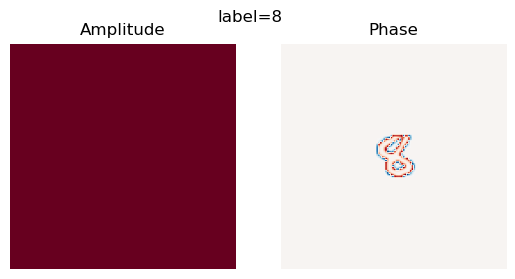

In [3]:
BATCH_SIZE = 500
IMG_SIZE = 32
N_pixels = 128
PADDING = (N_pixels - IMG_SIZE) // 2  # 避免边缘信息丢失

# 数据预处理并加载
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE, IMG_SIZE))])
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定义一个绘图函数
plt.rcParams['figure.figsize'] = (6.4, 4.8)
def image_plot(image_phase, label):
    cmap='RdBu'
    norm = np.absolute(image_phase.cpu().numpy())
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.round(norm, 5), cmap=cmap) # 显示图片每个像素点的振幅
    ax1.axis('off')
    ax1.set_title('Amplitude')
    ax2.imshow(np.angle(image_phase.cpu().numpy()), cmap=cmap)
    ax2.axis('off')  # 不显示坐标轴
    ax2.set_title('Phase')
    fig.suptitle("label={}".format(label), x=0.5, y=0.8)
#     fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax2)
    plt.show()

for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    images_padded = F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING))
    images_E = torch.sqrt(images_padded)
    images_phase = torch.exp(1j*2.0*np.pi*images_E) # 转换为相位图像
    labels = labels.to(device)

    
#     print(i, images_phase[0].shape, labels[0].shape)
    '''
        每一个周期，共300个批次（i=0~299），一共60000个数据；
        train_dataloader包含300个批次，包括整个训练集；
        每一批次一共200张图片，对应200个标签, len(images[0])=1；
        images包含一个批次的200张图片（image[0].shape=torch.Size([1,28,28])），labels包含一个批次的200个标签，标签范围为0~9
    '''

    # 每100个批次绘制第一张图片（含shuffle导致每次运行结果不一样）
    if (i + 1) % 100 == 0:
        classes = torch.unique(labels).cpu().numpy()
        classes_num = len(classes)
        print('batch_number [{}/{}]'.format(i + 1, len(train_dataloader)))
        print('classes of the first batch: {}, number of classes: {}'.format(classes, classes_num))#  第一个batch的总类
        image_plot(images_phase[0], labels[0])


In [4]:
# 检查一个batch的图片大小
images_E.shape

torch.Size([500, 128, 128])

### ***Diffractive Layer***

In [5]:
class Diffractive(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为532e-9，网格总数50，网格大小10e-6，z方向传播0.002。
    def __init__(self, N_mesh):
        super(Diffractive, self).__init__() # 初始化父类
        self.wl = 532e-9
        self.DISCRETIZATION_STEP = 1e-6
        self.z_step = 5e-6
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = torch.fft.fftshift(torch.fft.fftfreq(N_mesh, d = self.DISCRETIZATION_STEP))
        fy = torch.fft.fftshift(torch.fft.fftfreq(N_mesh, d = self.DISCRETIZATION_STEP))
        fxx, fyy = torch.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * torch.pi)**2 * ((1. / self.wl) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = torch.sqrt(torch.abs(argument))
        kz = torch.where(argument >= 0, tmp, 1j*tmp).clone().detach()
        self.phase = torch.exp(1j * kz * self.z_step).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        E = E.to(device)
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c) # 将零频移至张量中心
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * self.phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

### ***Propagation Layer***

In [6]:
# 衍射演化
'''
训练用
'''
class Propagation_Layer(torch.nn.Module):
    # 观察样本经过空间衍射传播的变化
    def __init__(self):
        super(Propagation_Layer, self).__init__() # 初始化父类
        self.wl = 532e-9
        self.N_mesh = 128
        self.number_of_z_steps = 128
        
    def forward(self, E0):
        full_cross_section = E0.to(device) # 将计算相位板的图片尺寸转化成计算传输场的图片尺寸
        diffraction_step = Diffractive(N_mesh = self.N_mesh).to(device)
        z_ind = torch.arange(0, self.number_of_z_steps)
        with torch.enable_grad():
            for ind in z_ind:
                full_cross_section = diffraction_step(full_cross_section)
        return full_cross_section  # 训练用这个

In [6]:
'''
查看衍射传输场用
'''
class Propagation_Layer(torch.nn.Module):
    # 观察样本经过空间衍射传播的变化
    def __init__(self):
        super(Propagation_Layer, self).__init__() # 初始化父类
        self.wl = 532e-9
        self.N_mesh = 128
        self.number_of_z_steps = 128
        self.BATCH_SIZE = 500
        
    def forward(self, E0):
        temp = E0.to(device) # 将计算相位板的图片尺寸转化成计算传输场的图片尺寸
        diffraction_step = Diffractive(N_mesh = self.N_mesh).to(device)
        z_ind = torch.arange(0, self.number_of_z_steps)
        full_cross_section =  torch.zeros((len(z_ind), self.BATCH_SIZE, self.N_mesh, self.N_mesh),dtype = torch.complex64).to(device)
        full_cross_section[0] = temp
        with torch.no_grad():
            for ind in z_ind[1:]:
                full_cross_section[ind] = diffraction_step(full_cross_section[ind-1])
        return full_cross_section   # 画传输图用这个

In [7]:
# 样本首先经过一个传输层，再被送入一个相位板。    
wl = 532e-9
N_mesh = 128
DISCRETIZATION_STEP = 1.0e-6 # 网格大小
z_step = 5e-6 # z方向步长
number_of_z_steps = 128 # z方向步数
z_max = number_of_z_steps*z_step # z坐标

In [8]:
# 计算传输层
images_E = torch.sqrt(images_padded)
model = Propagation_Layer().to(device)
field = model(images_E)

In [8]:
images_E.requires_grad

False

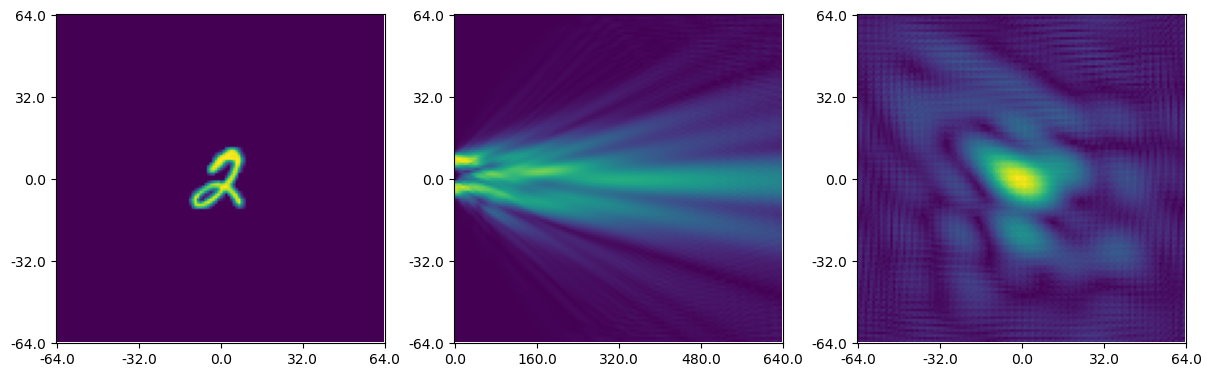

In [11]:
# 绘图
plt.rcParams["figure.figsize"] = (12, 4)
coord_limit = (N_mesh//2)*DISCRETIZATION_STEP # 建立xy坐标系
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout='constrained')

# input
XY_field_in = torch.abs(field[0, -1])
ax1.imshow(XY_field_in.cpu().numpy())
ax1.set_xticks(np.arange(0,N_mesh+1,np.floor(N_mesh/4)), np.round(1e6*np.arange(-coord_limit, 1.1*coord_limit, 0.5*coord_limit), 3))
ax1.set_yticks(np.arange(0,N_mesh+1,np.floor(N_mesh/4)), np.round(1e6*np.arange(coord_limit, -1.1*coord_limit, -0.5*coord_limit), 3))

# yz cross-section
YZ_field = torch.abs(field[:, -1, :, N_mesh//2]).T
ax2.imshow(YZ_field.cpu().numpy())
ax2.set_xticks(np.arange(0,number_of_z_steps+1,np.floor(number_of_z_steps/4)), np.round(1e6*np.arange(0, 1.1*z_max, 0.25*z_max), 3))
ax2.sharey(ax1)

# output
XY_field_out = torch.abs(field[-1, -1])
ax3.imshow(XY_field_out.cpu().numpy())
ax3.sharex(ax1)
ax3.sharey(ax1)

In [9]:
# 送入相位板
class Diffractive_Layer(torch.nn.Module):
    # 观察样本经过空间衍射传播的变化
    def __init__(self):
        super(Diffractive_Layer, self).__init__() # 初始化父类
        self.N_pixels = 128
        
    def forward(self, E0):
        with torch.enable_grad():
            E_output = Diffractive(N_mesh = self.N_pixels)(E0)
        return E_output

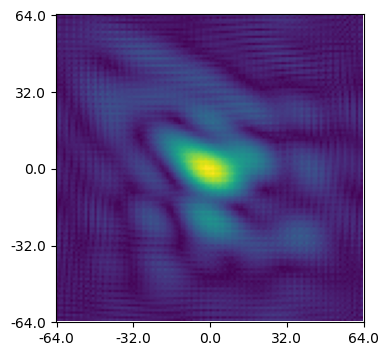

In [13]:
# 查看batch最后一个图片经过零相位板后的结果
model = Diffractive_Layer().to(device)
E_output = model(field[-1])
XY_field = torch.abs(E_output).cpu().numpy()[-1]
ax = plt.subplot()
ax.imshow(XY_field)
ax.sharex(ax1)
ax.sharey(ax1)


### ***Detectors Layer***

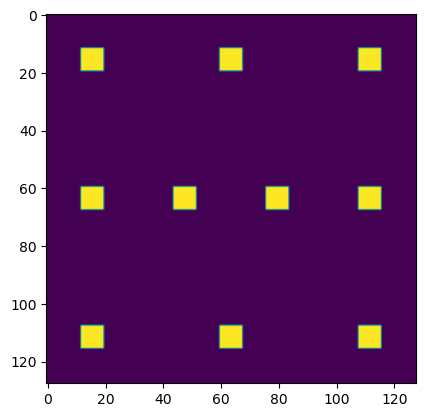

In [14]:
# 生成一行探测器。指定探测器个数N_det，在x方向上生成齐高等间距det_step的一组探测器
# left，right，up和down分别是该行矩形探测器的四个顶点坐标。
def generate_det_row(det_size, start_pos_x, start_pos_y, det_step, N_det):
    p = []
    for i in range(N_det):
        left = start_pos_x+i*(int(det_step)+det_size)
        right = left + det_size
        up = start_pos_y
        down = start_pos_y + det_size
        p.append((up, down, left, right))
    return p

# 生成三行探测器。利用generate_det_row函数生成三行等间距矩形探测器。
def set_det_pos(det_size = 20, start_pos_x = 46, start_pos_y = 46, 
                N_det_sets = [3, 4, 3], det_steps_x = [5, 3, 5], det_steps_y = 5):
    p = []
    for i in range(len(N_det_sets)):
        p.append(generate_det_row(det_size, start_pos_x, start_pos_y+i*(det_steps_y+1)
                                  *det_size, det_steps_x[i]*det_size, N_det_sets[i]))
    return list(itertools.chain.from_iterable(p))

# def set_det_pos(det_size=20, start_pos_x = 46, start_pos_y = 46):
#     p = []
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y, 2*det_size, 3))
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y+3*det_size, 1*det_size, 4))
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y+6*det_size, 2*det_size, 3))
#     return list(itertools.chain.from_iterable(p))

# 获取最终衍射光强在各个探测器上的分布情况
def detector_region(Int):
    detectors_list = []
    full_Int = Int.sum(dim=(1,2)) # 统计总光强
    for det_x0, det_x1, det_y0, det_y1 in detector_pos: # 计算各个探测器区间内的光强占比
        detectors_list.append((Int[:, det_x0 : det_x1, det_y0 : det_y1].sum(dim=(1, 2))/full_Int).unsqueeze(-1))        
    return torch.cat(detectors_list, dim = 1)

# 指定生成的十个探测器的位置。
# detector_pos = [
#     (46, 66, 46, 66),
#     (46, 66, 106, 126),
#     (46, 66, 166, 186),
#     (106, 126, 46, 66),
#     (106, 126, 86, 106),
#     (106, 126, 126, 146),
#     (106, 126, 166, 186),
#     (166, 186, 46, 66),
#     (166, 186, 106, 126),
#     (166, 186, 166, 186)

# 定义探测器模型基本参数
det_size = 8
det_pad = (N_mesh - 13*det_size)//2
detector_pos = set_det_pos(det_size, det_pad, det_pad)

# 定义探测器层的图片张量
labels_image_tensors=torch.zeros((10,N_mesh,N_mesh), device = device, dtype = torch.double)
for ind, pos in enumerate(detector_pos):
    pos_l, pos_r, pos_u, pos_d = pos
    labels_image_tensors[ind, pos_l:pos_r, pos_u:pos_d] = 1 # 设置探测器区域
    labels_image_tensors[ind] = labels_image_tensors[ind]/labels_image_tensors[ind].sum() # 归一化探测器层

plt.imshow(labels_image_tensors.cpu().numpy().sum(axis = 0)) # 查看探测器层

In [15]:
class Diffractive_Module(torch.nn.Module):
    def __init__(self):
        super(Diffractive_Module, self).__init__() # 初始化父类
    
    def forward(self, E_input):
        var = Propagation_Layer()(E_input).to(device)
        E_output = Diffractive_Layer()(var)
        return E_output

### ***D2NN***

In [16]:
class DNN(torch.nn.Module):
    def __init__(self, num_layers = 5):
        super(DNN, self).__init__()
        self.N_pixels = 128
        
        # 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
        self.phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
                                                          astype('float32')-0.5)) for _ in range(num_layers)]
#         self.phase = [torch.nn.Parameter(torch.from_numpy(np.zeros([self.N_pixels, self.N_pixels]))) for _ in range(num_layers)]
        # 向网络中添加每层相位板的参数
        for i in range(num_layers):
            self.register_parameter("phase" + "_" + str(i), self.phase[i])
        
        # 定义中间的衍射层
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Module() for _ in range(num_layers)])
#         self.diffractive_layer1 = Diffractive_Module()
#         self.diffractive_layer2 = Diffractive_Module()
#         self.diffractive_layer3 = Diffractive_Module()
#         self.diffractive_layer4 = Diffractive_Module()
#         self.diffractive_layer5 = Diffractive_Module()
        # 定义最后的探测层
        self.last_propagation_layer = Propagation_Layer()
        self.sofmax = torch.nn.Softmax(dim=-1)
    
    # 计算多层衍射前向传播
    def forward(self, E):
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            # 这里相当于加了一层sigmoid非线性激活，将相位控制在0到2pi
#             constr_phase = 2*torch.pi*torch.sigmoid(self.phase[index])
            constr_phase = 2*torch.pi*self.phase[index]
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase

#         constr_phase = 2*torch.pi*self.phase[0]
#         exp_j_phase = torch.exp(1j*constr_phase)
#         diff1 = self.diffractive_layer1(E) * exp_j_phase
        
#         constr_phase = 2*torch.pi*self.phase[1]
#         exp_j_phase = torch.exp(1j*constr_phase)
#         diff2 = self.diffractive_layer2(diff1) * exp_j_phase
        
#         constr_phase = 2*torch.pi*self.phase[2]
#         exp_j_phase = torch.exp(1j*constr_phase)
#         diff3 = self.diffractive_layer3(diff2) * exp_j_phase
        
#         constr_phase = 2*torch.pi*self.phase[3]
#         exp_j_phase = torch.exp(1j*constr_phase)
#         diff4 = self.diffractive_layer4(diff3) * exp_j_phase
        
#         constr_phase = 2*torch.pi*self.phase[4]
#         exp_j_phase = torch.exp(1j*constr_phase)
#         diff5 = self.diffractive_layer5(diff4) * exp_j_phase
        
#         E = self.last_propagation_layer(diff5)
        E = self.last_propagation_layer(E)
        Int = torch.abs(E)**2
#         output = self.sofmax(detector_region(Int))
        output = detector_region(Int)
        return output, Int

In [17]:
model = DNN().to(device)
print(model)

DNN(
  (diffractive_layers): ModuleList(
    (0): Diffractive_Module()
    (1): Diffractive_Module()
    (2): Diffractive_Module()
    (3): Diffractive_Module()
    (4): Diffractive_Module()
  )
  (last_propagation_layer): Propagation_Layer()
  (sofmax): Softmax(dim=-1)
)


### ***Training***

In [18]:
# 定义训练函数
def train(model, loss_function, optimizer, trainloader, testloader, epochs =10,  device=device):
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    best_acc = 0
    for epoch in range(epochs):
        ep_loss = 0
        # 每个epoch开始时启动Batch_Normalization和Dropout。BN层能够用到每一批数据的均值和方差，Dropout随机取一部分网络连接来训练更新参数。
        model.train()
        correct = 0
        total = 0
        # 加载进度条
        for images, labels in tqdm(trainloader):
            
            images = images.to(device)
            images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
            labels = labels.to(device)
#             det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
            det_labels = labels_image_tensors[labels] # 定义各标签的探测器层张量
            det_labels = det_labels.to(device).to(dtype=torch.float64)
            
            optimizer.zero_grad() # 梯度清零
            out_label, out_img = model(images) # 得到预测各个探测器上的光强分布以及探测层光强分布
            out_img = out_img.to(device).to(dtype=torch.float64)
            out_label = out_label.to(device).to(dtype=torch.float64)
            
            _, predicted = torch.max(out_label.data, 1) # 找到光强分布占比最大的探测器，并作为预测结果
            correct += (predicted == labels).sum().item() # 得到一个batch的预测结果。如果预测值等于标签值，则正确值加一。
            total += labels.size(0) # 得到一个batch的标签总数

            full_int_img = out_img.sum(axis=(1,2))
            loss = loss_function(out_img/full_int_img[:,None,None], det_labels) # 光强分布归一化后送入损失函数（与完美探测结果进行比较）
            #loss = loss_function(out_label, det_labels)
            
            loss.requires_grad_(True)
            loss.backward() # 反向传播
            optimizer.step() # 参数更新
            ep_loss += loss.item() # 更新本次epoch的损失
        train_loss_hist.append(ep_loss /len(trainloader)) # 计算平均损失
        train_acc_hist.append(correct /total) # 计算准确率
        #train_acc_hist.append(validate(model, trainloader,device))

        #test_acc_hist.append(validate(model, testloader,device))
        # if test_acc_hist[-1][0]>best_acc:
        #     best_model=copy.deepcopy(model)
        
        ep_loss = 0
        # 不启用Batch Normalization和Dropout。测试过程中要保证BN层的均值和方差不变，且利用到了所有网络连接，即不进行随机舍弃神经元。
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # 停止梯度更新
            for images, labels in tqdm(testloader):
                images = images.to(device)
                images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
                labels = labels.to(device)
                #det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
                det_labels = labels_image_tensors[labels]

                out_label, out_img = model(images)
                _, predicted = torch.max(out_label.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                full_int_img = out_img.sum(axis=(1,2))
                loss = loss_function(out_img/full_int_img[:,None,None], det_labels)
                #loss = loss_function(out_label, det_labels)
                
                #直接计算损失，无反向传播和梯度更新。
                ep_loss += loss.item()
        test_loss_hist.append(ep_loss / len(testloader))
        test_acc_hist.append(correct / total)
        # 如果最后一次训练的准确率大于之前最好的准确率，则将最后一次的模型保存为最佳模型。
        if test_acc_hist[-1]>best_acc:
             best_model = copy.deepcopy(model)

        print(f"Epoch={epoch} train loss={train_loss_hist[epoch]:.4}, test loss={test_loss_hist[epoch]:.4}")
        print(f"train acc={train_acc_hist[epoch]:.4}, test acc={test_acc_hist[epoch]:.4}")
        print("-----------------------")
        
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model

In [35]:
def custom_loss(imgs, det_labels):
    full_int = imgs.sum(dim=(1,2))
    loss = 1 - (imgs*det_labels).sum(dim=(1,2))/full_int
    return loss.mean()

In [19]:
# 定义模型，损失函数和优化器
model = DNN().to(device)
# criterion = custom_loss
# criterion = torch.nn.CrossEntropyLoss().to(device)
criterion = torch.nn.MSELoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [15]:
# 正式开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 1,  device = device)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.88s/it]

Epoch=0 train loss=6.58, test loss=5.789
train acc=0.6046, test acc=0.7035
-----------------------


### ***Saving***

In [16]:
torch.save(model, 'MNIST_Fourier_0.70.pth')

In [17]:
# 释放显存
torch.cuda.empty_cache()

### ***Loading***

In [20]:
model = torch.load('MNIST_Fourier_0.70.pth')

### ***Data Analysis***

In [21]:
# 查看
def visualize(image, label):
    image_padded = F.pad(image, pad=(PADDING, PADDING, PADDING, PADDING))
    image_E = torch.sqrt(image_padded)
    out = model(image_E.to(device))
    output_image = out[1].detach().cpu()[0]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image_E[0], interpolation='none')
    ax1.set_title(f'Input image with\n total intensity {image_padded[0].sum():.2f}')
    ax2.imshow(output_image, interpolation='none')
    ax2.set_title(f'Output image with\n total intensity {output_image.sum():.2f}')
    fig.suptitle("label={}".format(label), x=0.51, y=0.85)
    plt.show()

def mask_visualiztion():
    for ind, mask in enumerate(model.phase):
        plt.imshow(torch.sigmoid(mask.detach().cpu())*360, interpolation = 'none')
        #plt.imshow(mask.detach().cpu()*180/np.pi, interpolation='none')
        plt.title(f'Mask of layer {ind+1}')
        plt.colorbar()
        plt.show()

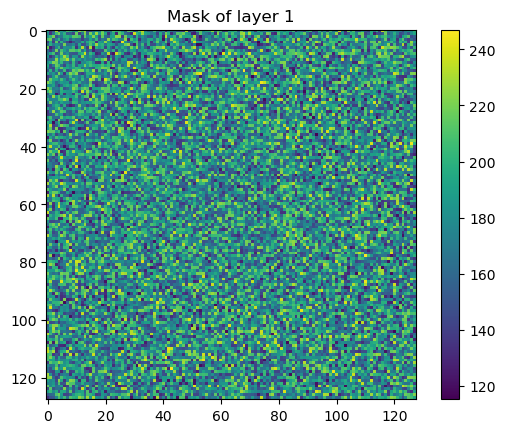

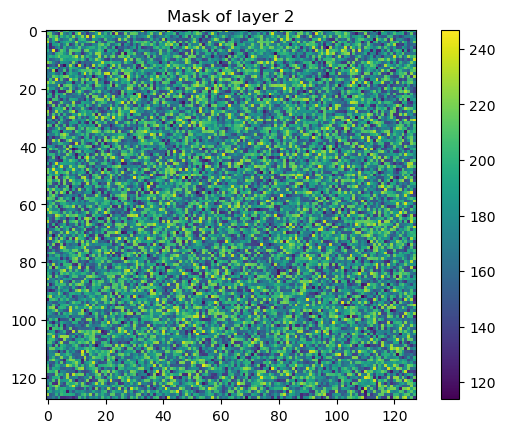

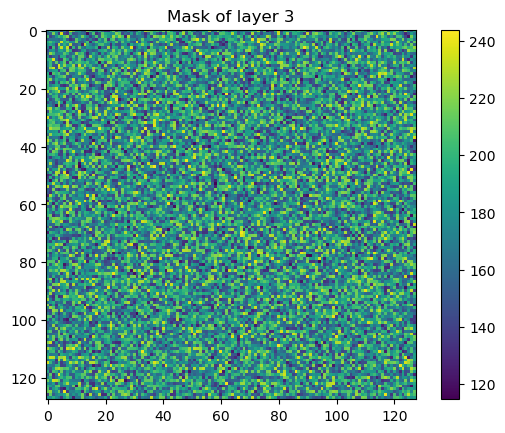

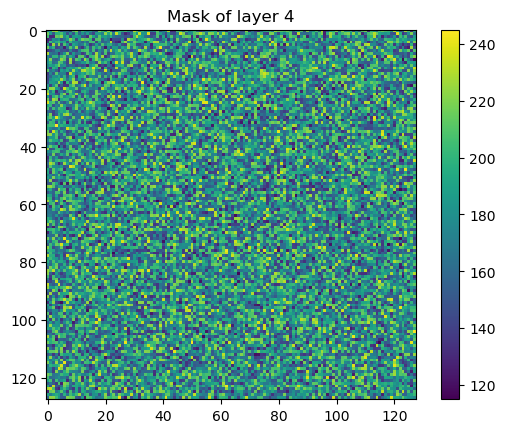

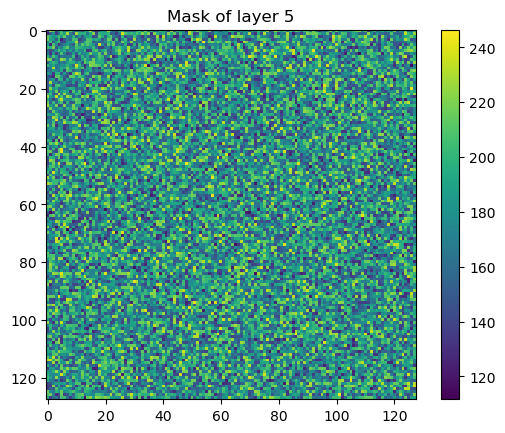

In [22]:
mask_visualiztion()

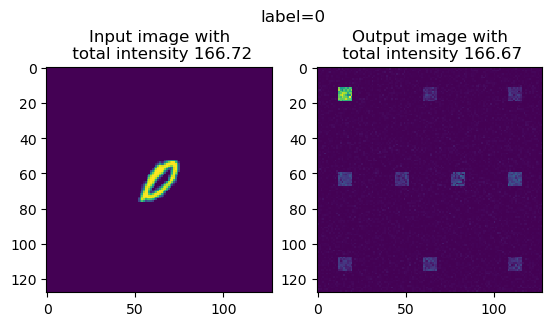

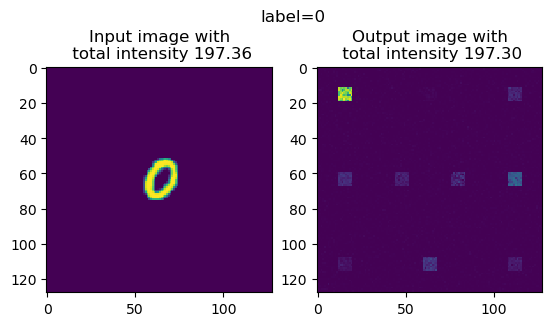

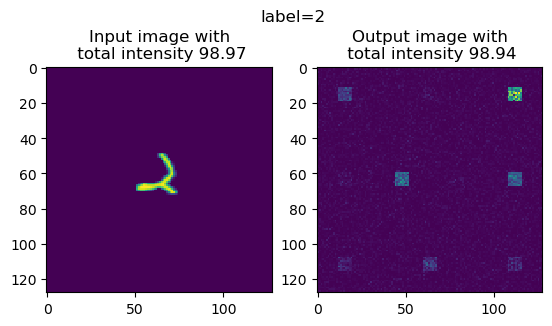

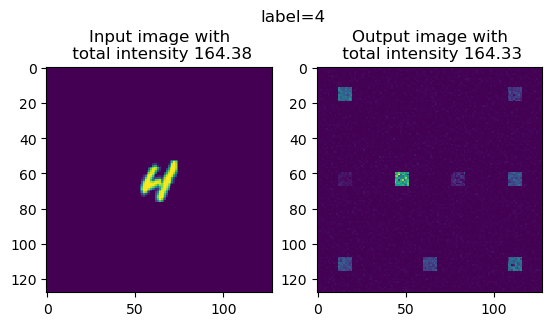

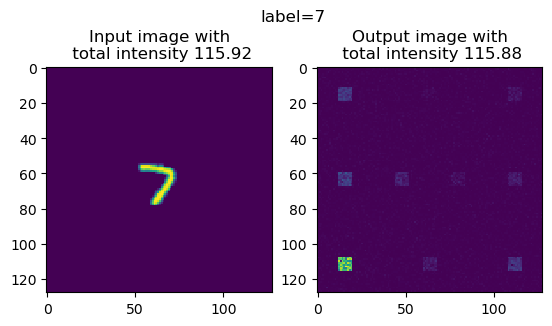

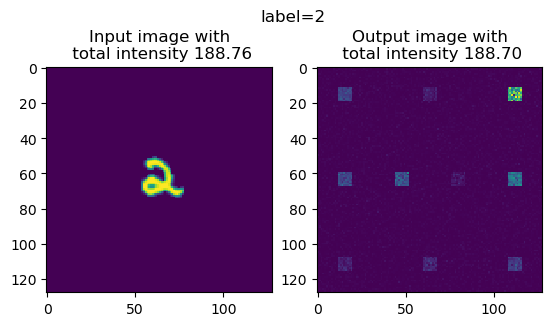

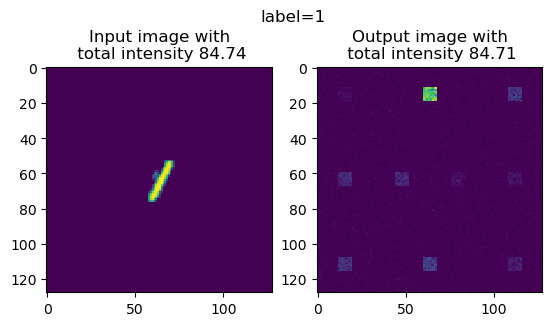

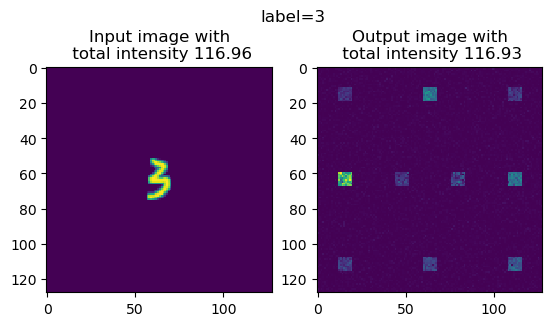

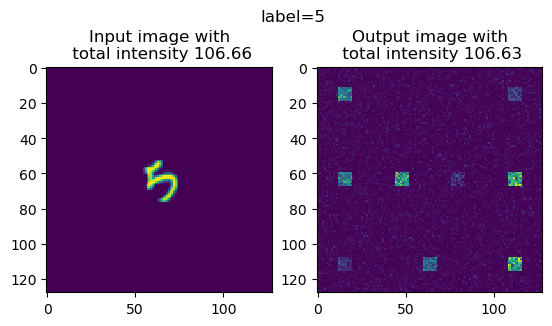

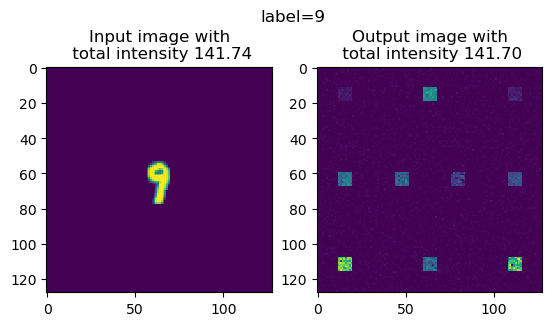

In [23]:
rand_ind = np.random.choice(range(len(val_dataset)), size=10, replace=False)
for ind in rand_ind:
    visualize(val_dataset[ind][0], val_dataset[ind][1])

In [27]:
def confusion_matrix(predicted, labels, conf_matrix):
    for p, t in zip(predicted, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
#首先定义一个 分类数*分类数 的空混淆矩阵
conf_matrix = torch.zeros(classes_num, classes_num)
# 使用torch.no_grad()可以显著降低测试用例的GPU占用
with torch.no_grad(): # 停止梯度更新
    for i, (images, labels) in enumerate(val_dataloader):
        images = images.to(device)
        images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
        labels = labels.to(device)

        out_labels, out_images = model(images)
        _, predicted = torch.max(out_labels.data, 1)
        
        #记录混淆矩阵参数
        conf_matrix = confusion_matrix(predicted, labels, conf_matrix)
        conf_matrix = conf_matrix.cpu()

In [28]:
conf_matrix = np.array(conf_matrix)# 将混淆矩阵从gpu转到cpu再转到np
corrects = conf_matrix.diagonal(offset = 0)#抽取对角线的每种分类的识别正确个数
per_classes = conf_matrix.sum(axis = 1)#抽取每个分类数据总的测试条数

print("混淆矩阵总元素个数：{},测试集总个数:{}".format(int(np.sum(conf_matrix)), BATCH_SIZE*len(val_dataloader)))
np.set_printoptions(suppress=True) 
print(conf_matrix)

# 获取每种label的识别准确率
percent = [rate*100 for rate in corrects/per_classes]
per_classes = list(per_classes)
corrects = list(corrects)

print("每种标签总个数：{}".format('  '.join(['{:.0f}'.format(i) for i in per_classes])))
print("每种标签预测正确的个数：{}".format('  '.join(['{:.0f}'.format(i) for i in corrects])))
print("每种标签的识别准确率为：{}".format('%  '.join(['{:.1f}'.format(i) for i in percent])), end='%')

混淆矩阵总元素个数：10000,测试集总个数:10000
[[ 946.    0.   95.   41.   18.  271.   82.   13.   92.   52.]
 [   1. 1120.  169.   45.   70.  136.   38.   72.  201.   63.]
 [   2.    3.  631.   12.    0.    1.    2.   18.    5.    8.]
 [   6.    4.   29.  865.    7.  314.    2.    1.  178.   20.]
 [   0.    0.   12.    0.  747.   15.    3.    3.    9.   52.]
 [   0.    0.    0.    0.    0.    1.    0.    0.    0.    0.]
 [  21.    5.   42.   12.   62.   46.  831.    4.   37.    7.]
 [   1.    0.   38.   25.   13.   54.    0.  906.   53.  198.]
 [   3.    3.   16.    5.    2.   29.    0.    2.  380.    1.]
 [   0.    0.    0.    5.   63.   25.    0.    9.   19.  608.]]
每种标签总个数：1610  1915  682  1426  841  1  1067  1288  441  729
每种标签预测正确的个数：946  1120  631  865  747  1  831  906  380  608
每种标签的识别准确率为：58.8%  58.5%  92.5%  60.7%  88.8%  100.0%  77.9%  70.3%  86.2%  83.4%

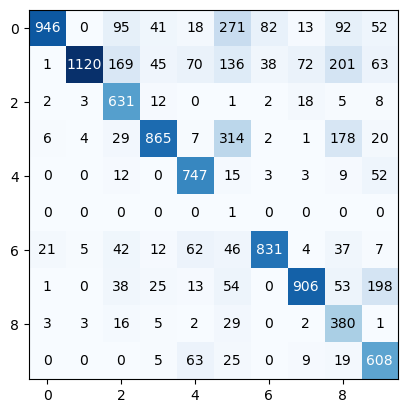

In [29]:
# 绘制混淆矩阵
label_ticks = list()
for i in range(classes_num):
    label_ticks = label_ticks + ['{}'.format(classes[i])]

# 显示数据
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
thresh = conf_matrix.max() / 2	#数值颜色阈值，如果数值超过这个，就颜色加深。
for i in range(classes_num):
    for j in range(classes_num):
        info = int(conf_matrix[j, i])
        plt.text(i, j, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")
plt.show()

In [90]:
phase = []
for param in model.named_parameters():
    phase.append(param[1])

In [147]:
phase[0].shape

torch.Size([128, 128])

In [171]:
class DNN_test(torch.nn.Module):
    def __init__(self, num_layers = 5, phase = []):
        super(DNN_test, self).__init__()
        self.N_pixels = 128
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Module() for _ in range(num_layers)])
        self.last_propagation_layer = Propagation_Layer()
    
    # 计算多层衍射前向传播
    def forward(self, E):
        E_out = []
        Int = []
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            # 这里相当于加了一层sigmoid非线性激活，将相位控制在0到2pi
#             constr_phase = 2*torch.pi*torch.sigmoid(self.phase[index])
            constr_phase = 2*torch.pi*phase[index]
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase
            E_out.append(E)
        E_out.append(self.last_propagation_layer(E_out[-1]))
        for i in range(len(E_out)):
            Int.append(torch.abs(E_out[i])**2)
        return Int

In [172]:
model_test = DNN_test(phase = phase)

In [173]:
mid_img = model_test(images_E)

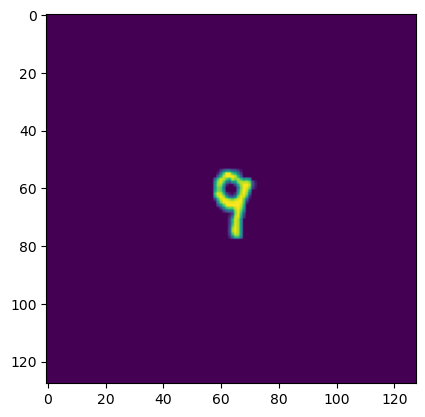

In [182]:
plt.imshow(images_E[1].cpu().detach().numpy())

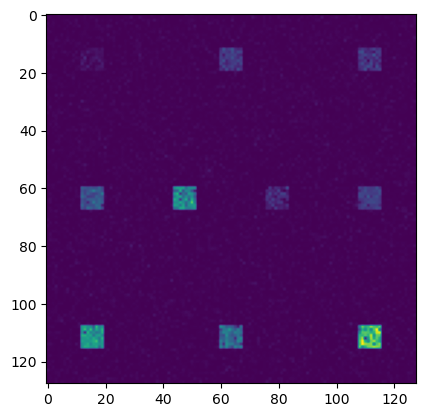

In [190]:
plt.imshow(mid_img[5][1].cpu().detach().numpy())